# **KNN**

## **Implementacion**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import csv

from math import sqrt, inf
from random import randint

In [11]:
class Node:
  def __init__(self, parent, x, area):
    self.parent = parent
    self.x = x
    self.childs = [None, None]  # [left_child, right_child]
    # El area es un vector 2*len(x)-dimensional y representa un hipercubo, donde cada
    # par de elementos representan los valores minimos y maximos de una determinada coordenada.
    # Por ejemplo, si len(x) == 2, entonces area = [a, b, c, d] representa el cuadrado:
    #      a <= x[0] <= b;    c <= x[1] <= d
    self.area = area

class KNN:
  def __init__(self, X):
    self.X = X
    
  def d(self, x, y):
    """ Distancia euclidiana entre dos vectores. """
    return np.linalg.norm(x-y)
    
  def build_kd_tree(self, X=None, parent=None, right=True, d=0, root=True, area=None):
    """ Construimos un KD-Tree.
    INPUT:
        X: Conjunto de datos del nodo actual.
        parent: Nodo padre del nodo actual.
        right: Indica si el nodo actual es el hijo derecho.
        d: Atributo que se usara para realizar la division binaria de los datos.
        root: Indica si el nodo actual es la raiz de todo el arbol.
        area: Area que representa el nodo actual.
    """
    # Si el nodo es la raiz, entonces tomamos todos los datos y el area es todo el espacio.
    if root: 
      X = self.X
      area = [-inf,inf]*len(X[0])
        
    # Si no hay elementos, no se crea ningun nodo
    if len(X) == 0: return
    # Si solo hay un elemento, creamos un nodo con ese unico elemento.
    elif len(X) == 1:
      node = Node(parent, X[0], area)
      # Verificamos que el nodo no sea la raiz, lo que significaria que solo hay un dato.
      if not root: parent.childs[int(right)] = node
    # Si hay mas de un dato.
    else:
      # Ordenamos los elementos segun el d-esimo atributo.
      X_c = X.copy()
      X_c.sort(key = lambda x: x[d])
      # Obtenemos la mediana.
      m = int(len(X_c)/2)
      x_m = X_c[m]
      # Creamos un nuevo nodo donde se almacenara la mediana.
      node = Node(parent, x_m, area)
      if not root: parent.childs[int(right)] = node
      else: self.kd_tree = node
      # Llamamos recursivamente la funcion para los hijos izquierdo y derecho.
      # Derecho
      X_r = X_c[m+1:].copy()
      area_r = area.copy()
      area_r[2*d] = x_m[d]
      # Izquierdo
      X_l = X_c[:m].copy()
      area_l = area.copy()
      area_l[2*d+1] = x_m[d]
      # Llamada recursiva
      self.build_kd_tree(X_l, node, False, (d+1)%len(x_m), False, area_l)
      self.build_kd_tree(X_r, node, True, (d+1)%len(x_m), False, area_r)

  def knn(self, x, k, method="Force"):
    """ Calculamos los k vecinos mas cercanos de un determinado elemento. 
    INPUT:
        x: Elemento.
        k: Numero de vecinos.
        method: Metodo que se realizara para calcular los k vecinos. Solo puede
            tomar el valor de "Force" y "KD-Tree" """
    # Calculamos los k vecinos usando fuerza bruta.
    if method == "Force":
      # Almacenamoslas distancias y los vecinos correspondientes.
      distances, neighbors = [], []
      # Por cada elemento del dataset.
      for x_i in self.X:
        # Calculamos la distancia.
        dist = self.d(x, x_i)
        find = False
        # Usando la idea de insertion-sort, insertamos el elemento segun la distancia
        # obtenida.
        for i in range(len(distances)):
          if distances[i] > dist:
            A, B = distances[:i].copy(), neighbors[:i].copy()
            A.append(dist)
            B.append(x_i)
            A.extend(distances[i:])
            B.extend(neighbors[i:])
            distances, neighbors = A.copy(), B.copy()
            find = True
            break
        if not find: 
          distances.append(dist)
          neighbors.append(x_i)
      # Retornamos los primeros k elementos que seran los de menor distancia.
      return neighbors[:k]
    
    # Calculamos los k vecinos utilizando el KD-Tree.
    elif method == "KD-Tree":
      # Aqui almacenaremos las k distancias minimas.
      self.min_d = [inf]*k
      # Y aqui los k vecinos.
      self.neighbors = [None]*k
        
      self.knn_kd_tree(x, self.kd_tree, 0)
        
      neighbors = self.neighbors
      # Nos aseguramos de eliminar estos atributos.
      self.min_d = None
      self.neighbors = None
      return neighbors

  def knn_kd_tree(self, x, node, d):
    # Verificamos si el punto se encuentra fuera del hipercubo definido por el nodo actual.
    if not all(node.area[2*i] <= x[i] <= node.area[2*i+1] for i in range(len(x))):
      # Por cada dimension, verificamos si el punto se encuentra dentro de los lados
      # correspondientes al hipercubo
      p = []
      for i in range(len(x)):
        # Si no es asi, almacenamos la coordenada del punto que se encuentra fuera del
        # lado del hipercubo.
        if node.area[2*i] > x[i]: p.append(node.area[2*i])
        elif x[i] > node.area[2*i+1]: p.append(node.area[2*i+1])
        else: p.append(x[i])
        
            
      # Calculamos la distancia entre las coordenadas del punto fuera del hipercubo y
      # la interseccion de los lados correspondientes. Si es mayor a la mayor de las 
      # distancias menores actuales, entonces no existe ninguno punto dentro del hipercubo
      # que este mas cerca que alguno de los actuales k vecinos.
      dist = self.d(np.array(p), x)
      if dist >= self.min_d[-1]: return
        
    # Calculamos la distancia entre el punto y la raiz actual. Verificamos si es menor
    # que alguna de las menores distancias.
    dist = self.d(x, node.x)
    for i in range(len(self.min_d)):
      if dist < self.min_d[i]:
        # Copiamos los i-1-esimos vecinos actuales
        aux_d, aux_n = self.min_d[:i].copy(), self.neighbors[:i].copy()
        # Agregamos el nuevo
        aux_d.append(dist)
        aux_n.append(node.x)
        # Agregamos los vecinos restantes, menos el ultimo que queda fuera.
        aux_d.extend(self.min_d[i:len(self.min_d)-1])
        aux_n.extend(self.neighbors[i:len(self.neighbors)-1])
        # Actualizamos.
        self.min_d, self.neighbors = aux_d, aux_n
        # Salimos del for
        break
        
    # Llamamos primero a la subdivision del arbol tal que el punto cumpla la condicion,
    # con la esperanza de que al llamar el segundo hijo, este pueda ser descartado facilmente.
    # Si no cumple ninguna, se recorre primero el hijo izquierdo (si no es nulo) y luego el derecho.
    if x[d] <= node.area[2*d+1] and node.childs[0] != None: 
      self.knn_kd_tree(x, node.childs[0], (d+1)%len(x))
      if node.childs[1] != None:
        self.knn_kd_tree(x, node.childs[1], (d+1)%len(x))
        
    elif x[d] >= node.area[2*d] and node.childs[1] != None: 
      self.knn_kd_tree(x, node.childs[1], (d+1)%len(x))
      if node.childs[0] != None:
        self.knn_kd_tree(x, node.childs[0], (d+1)%len(x))
    
    elif node.childs[0] != None: 
      self.knn_kd_tree(x, node.childs[0], (d+1)%len(x))
      if node.childs[1] != None:
        self.knn_kd_tree(x, node.childs[1], (d+1)%len(x))
        
    elif node.childs[1] != None:
      self.knn_kd_tree(x, node.childs[1], (d+1)%len(x))
    
  def radius_neighbors(self, x, r):
    # Aqui almacenamos los vecinos
    self.neighbors = []

    self.r_neighbors(x, self.kd_tree, 0, r)

    neighbors = self.neighbors
    # Nos aseguramos de eliminar estos atributos.
    self.neighbors = None
    return neighbors

  def r_neighbors(self, x, node, d, r):
    # Verificamos si el punto se encuentra fuera del hipercubo definido por el nodo actual.
    if not all(node.area[2*i] <= x[i] <= node.area[2*i+1] for i in range(len(x))):
      # Por cada dimension, verificamos si el punto se encuentra dentro de los lados
      # correspondientes al hipercubo
      p = []
      for i in range(len(x)):
        # Si no es asi, almacenamos la coordenada del punto que se encuentra fuera del
        # lado del hipercubo.
        if node.area[2*i] > x[i]: p.append(node.area[2*i])
        elif x[i] > node.area[2*i+1]: p.append(node.area[2*i+1])
        else: p.append(x[i])
        
            
      # Calculamos la distancia entre las coordenadas del punto fuera del hipercubo y
      # la interseccion de los lados correspondientes. Si es mayor al radio, no necesitamos
      # verificar mas esta rama.
      dist = self.d(np.array(p), x)
      if dist > r: return
        
    # Calculamos la distancia entre el punto y la raiz actual. Verificamos si es menor
    # que el raio
    dist = self.d(x, node.x)
    if dist < r: self.neighbors.append(node.x)
        
    # Llamamos primero a la subdivision del arbol tal que el punto cumpla la condicion,
    # con la esperanza de que al llamar el segundo hijo, este pueda ser descartado facilmente.
    # Si no cumple ninguna, se recorre primero el hijo izquierdo (si no es nulo) y luego el derecho.
    if x[d] <= node.area[2*d+1] and node.childs[0] != None: 
      self.r_neighbors(x, node.childs[0], (d+1)%len(x), r)
      if node.childs[1] != None:
        self.r_neighbors(x, node.childs[1], (d+1)%len(x), r)
        
    elif x[d] >= node.area[2*d] and node.childs[1] != None: 
      self.r_neighbors(x, node.childs[1], (d+1)%len(x), r)
      if node.childs[0] != None:
        self.r_neighbors(x, node.childs[0], (d+1)%len(x), r)
    
    elif node.childs[0] != None: 
      self.r_neighbors(x, node.childs[0], (d+1)%len(x), r)
      if node.childs[1] != None:
        self.r_neighbors(x, node.childs[1], (d+1)%len(x), r)
        
    elif node.childs[1] != None:
      self.r_neighbors(x, node.childs[1], (d+1)%len(x), r)


## **Lectura de Datos**

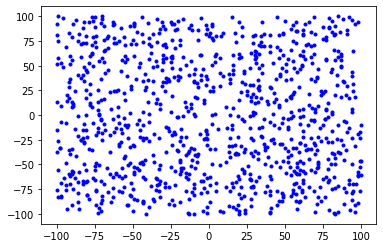

In [12]:
# Generamos los datos y los graficamos.
X = []
for i in range(1000):
  X.append(np.array([randint(-100, 100), randint(-100, 100)]))

# Agregamos los puntos en el plano 3D
plt.plot([x[0] for x in X], [x[1] for x in X], '.', c='b')

# Mostramos el gráfico
plt.show()

## **Resultados**

### **Fuerza bruta**

In [13]:
knn = KNN(X)

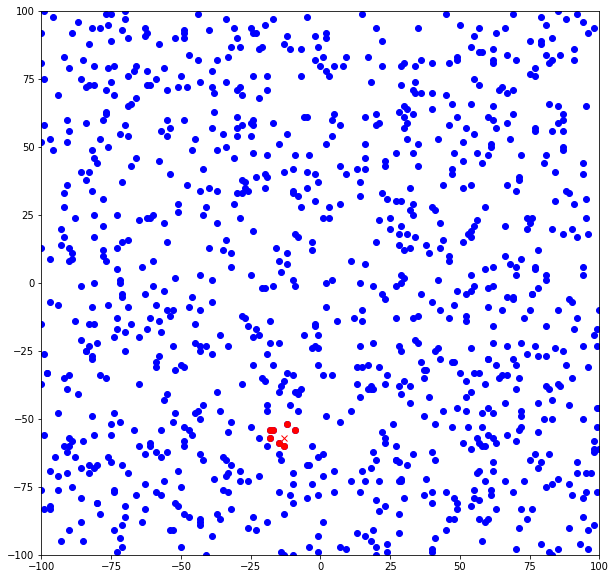

In [14]:
x = np.array([randint(-100, 100), randint(-100, 100)])
k = randint(1, 20)
neighbors = knn.knn(x, k)

plt.figure(figsize=(10,10))
plt.xlim(-100, 100)
plt.ylim(-100, 100)
# Agregamos los puntos en el plano 3D
plt.plot([x[0] for x in X], [x[1] for x in X], 'o', c='b')
plt.plot([n[0] for n in neighbors], 
            [n[1] for n in neighbors], 'o', c='r')
plt.plot([x[0]], [x[1]], 'x', c='r')

# Mostramos el gráfico
plt.show()

### **KD-Tree**

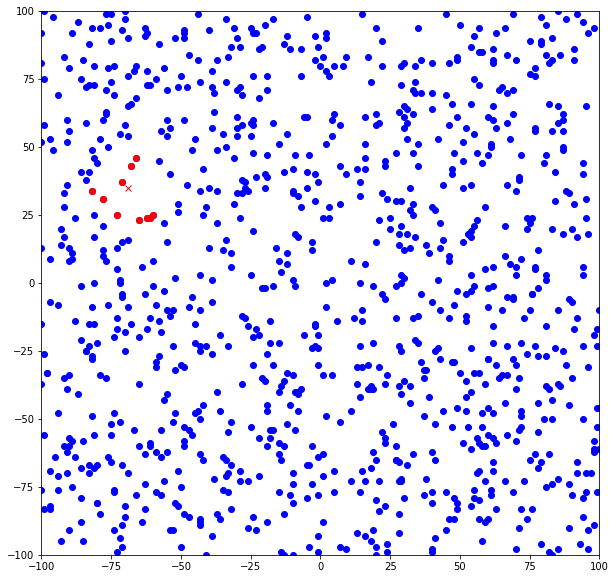

In [15]:
knn.build_kd_tree()
x = np.array([randint(-100, 100), randint(-100, 100)])
k = randint(1, 20)
neighbors = knn.knn(x, 10, method="KD-Tree")

plt.figure(figsize=(10,10))
plt.xlim(-100, 100)
plt.ylim(-100, 100)
# Agregamos los puntos en el plano 3D
plt.plot([x[0] for x in X], [x[1] for x in X], 'o', c='b')
plt.plot([n[0] for n in neighbors], [n[1] for n in neighbors], 'o', c='r')
plt.plot([x[0]], [x[1]], 'x', c='r')

# Mostramos el gráfico
plt.show()

### **Vecinos dentro de un radio**

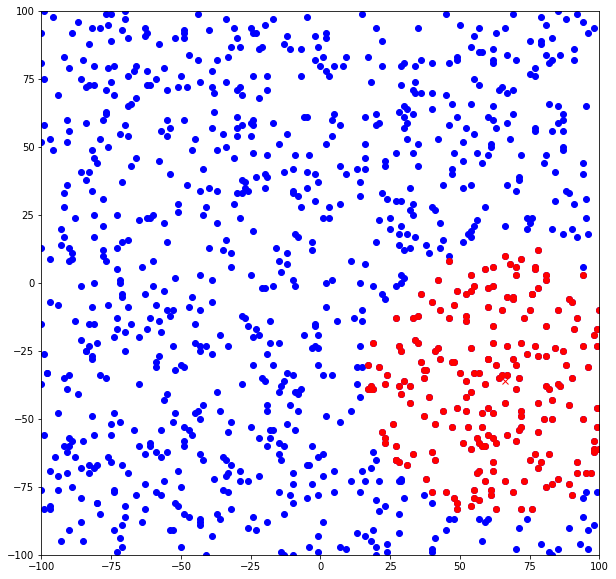

In [20]:
knn.build_kd_tree()
x = np.array([randint(-100, 100), randint(-100, 100)])
neighbors = knn.radius_neighbors(x, 50)

plt.figure(figsize=(10,10))
plt.xlim(-100, 100)
plt.ylim(-100, 100)
# Agregamos los puntos en el plano 3D
plt.plot([x[0] for x in X], [x[1] for x in X], 'o', c='b')
plt.plot([n[0] for n in neighbors], [n[1] for n in neighbors], 'o', c='r')
plt.plot([x[0]], [x[1]], 'x', c='r')

# Mostramos el gráfico
plt.show()